# Time Series Clustering with Pretrained Models

## Assignment Part F

This notebook demonstrates clustering of time series data using various techniques including:
1. Traditional time series clustering methods (DTW-based)
2. Feature-based clustering with TSFresh
3. Deep learning embeddings for time series

### What is Time Series Clustering?
Time series clustering groups similar temporal patterns together. Applications include:
- Stock market analysis (grouping similar stocks)
- Customer behavior segmentation
- Sensor data analysis
- Healthcare monitoring
- Energy consumption patterns

### Approaches:
1. **Distance-based**: Use specialized metrics like DTW (Dynamic Time Warping)
2. **Feature-based**: Extract features, then cluster
3. **Model-based**: Use deep learning to learn embeddings

## 1. Installation and Setup

In [1]:
# Install required libraries
!pip install tslearn -q
!pip install tsfresh -q
!pip install pandas numpy matplotlib seaborn scikit-learn -q
!pip install yfinance -q  # For downloading stock data
!pip install plotly -q

print("Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 8.9 MB/s eta 0:00:00
Installation complete!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series clustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
from tslearn.utils import to_time_series_dataset

# Feature extraction
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Stock data
import yfinance as yf

# Clustering and evaluation
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Time Series Data

We'll use real stock market data from Yahoo Finance to demonstrate time series clustering.

In [4]:
# Define stock tickers to analyze
# Mix of tech, finance, consumer, healthcare, energy sectors
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN',  # Tech
    'JPM', 'BAC', 'GS', 'WFC',         # Finance
    'PG', 'KO', 'WMT', 'MCD',          # Consumer
    'JNJ', 'PFE', 'UNH', 'ABBV',       # Healthcare
    'XOM', 'CVX', 'COP', 'SLB'         # Energy
]

# Download stock data
print("Downloading stock data from Yahoo Finance...")
print("This may take a minute...\n")

start_date = '2023-01-01'
end_date = '2024-01-01'

# Try downloading all at once (faster)
try:
    print("Attempting bulk download...")
    data_bulk = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker')

    # Extract Close prices for each ticker
    stock_data = {}
    for ticker in tickers:
        try:
            if ticker in data_bulk.columns.get_level_values(0):
                close_data = data_bulk[ticker]['Close']
                if len(close_data) > 0 and not close_data.isna().all():
                    stock_data[ticker] = close_data
                    print(f"{ticker}: ✓")
                else:
                    print(f"{ticker}: ✗ (no valid data)")
            else:
                print(f"{ticker}: ✗ (not in response)")
        except:
            print(f"{ticker}: ✗ (error extracting)")

    print(f"\n✓ Bulk download complete: {len(stock_data)}/{len(tickers)} stocks")

except Exception as e:
    print(f"Bulk download failed: {str(e)[:100]}")
    print("\nTrying individual downloads...\n")

    stock_data = {}
    for ticker in tickers:
        try:
            print(f"Downloading {ticker}...", end=' ')
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)

            if len(data) > 0:
                # Handle both single and multi-column formats
                if 'Close' in data.columns:
                    close_prices = data['Close']
                elif isinstance(data, pd.Series):
                    close_prices = data
                else:
                    # Data might be a single column DataFrame
                    close_prices = data.iloc[:, 0] if len(data.columns) > 0 else None

                if close_prices is not None and len(close_prices) > 0 and not close_prices.isna().all():
                    stock_data[ticker] = close_prices
                    print("✓")
                else:
                    print("✗ (no valid data)")
            else:
                print("✗ (empty)")
        except Exception as e:
            print(f"✗ ({str(e)[:30]})")

# Check if we got enough data
if len(stock_data) == 0:
    print("\n⚠ WARNING: Failed to download stock data from Yahoo Finance.")
    print("Creating synthetic time series data instead...\n")
    use_synthetic = True

elif len(stock_data) < 5:
    print(f"\n⚠ WARNING: Only {len(stock_data)} stocks downloaded successfully.")
    print("This is too few for meaningful clustering. Creating synthetic data instead...\n")
    use_synthetic = True

else:
    use_synthetic = False
    print(f"\n✓ Successfully downloaded data for {len(stock_data)} stocks")

# Generate synthetic data if needed
if use_synthetic:
    np.random.seed(42)
    n_days = 252  # Trading days in a year
    date_range = pd.date_range(start='2023-01-01', periods=n_days, freq='B')

    # Create synthetic stock data with different patterns
    synthetic_stocks = {}

    # Define sector parameters (mean return, volatility)
    sector_params = {
        'Tech': (0.001, 0.02),
        'Finance': (0.0005, 0.015),
        'Consumer': (0.0003, 0.01),
        'Healthcare': (0.0004, 0.012),
        'Energy': (0.0002, 0.025)
    }

    ticker_sectors = {
        'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'AMZN': 'Tech',
        'JPM': 'Finance', 'BAC': 'Finance', 'GS': 'Finance', 'WFC': 'Finance',
        'PG': 'Consumer', 'KO': 'Consumer', 'WMT': 'Consumer', 'MCD': 'Consumer',
        'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare', 'ABBV': 'Healthcare',
        'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy'
    }

    for ticker in tickers:
        sector = ticker_sectors.get(ticker, 'Finance')
        mu, sigma = sector_params[sector]

        # Add cyclical pattern for energy stocks
        if sector == 'Energy':
            cycle = 0.1 * np.sin(2 * np.pi * np.arange(n_days) / 60)
            returns = np.random.normal(mu, sigma, n_days) + cycle/100
        else:
            returns = np.random.normal(mu, sigma, n_days)

        price = 100 * (1 + returns).cumprod()
        synthetic_stocks[ticker] = pd.Series(price, index=date_range)

    df_stocks = pd.DataFrame(synthetic_stocks)
    print(f"✓ Created synthetic data for {len(df_stocks.columns)} stocks")

else:
    # Use real downloaded data
    # Create DataFrame from dictionary of Series
    try:
        # Align all series to the same index by using join
        df_stocks = pd.concat(stock_data, axis=1)
        df_stocks.columns = stock_data.keys()

        # Drop any rows with missing values
        initial_rows = len(df_stocks)
        df_stocks = df_stocks.dropna()

        if len(df_stocks) < 100:
            print(f"\n⚠ WARNING: Too few rows after cleaning ({len(df_stocks)} rows).")
            print("Creating synthetic data instead...\n")

            # Fallback to synthetic
            np.random.seed(42)
            n_days = 252
            date_range = pd.date_range(start='2023-01-01', periods=n_days, freq='B')

            sector_params = {
                'Tech': (0.001, 0.02),
                'Finance': (0.0005, 0.015),
                'Consumer': (0.0003, 0.01),
                'Healthcare': (0.0004, 0.012),
                'Energy': (0.0002, 0.025)
            }

            ticker_sectors = {
                'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'AMZN': 'Tech',
                'JPM': 'Finance', 'BAC': 'Finance', 'GS': 'Finance', 'WFC': 'Finance',
                'PG': 'Consumer', 'KO': 'Consumer', 'WMT': 'Consumer', 'MCD': 'Consumer',
                'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare', 'ABBV': 'Healthcare',
                'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy'
            }

            synthetic_stocks = {}
            for ticker in tickers:
                sector = ticker_sectors.get(ticker, 'Finance')
                mu, sigma = sector_params[sector]

                if sector == 'Energy':
                    cycle = 0.1 * np.sin(2 * np.pi * np.arange(n_days) / 60)
                    returns = np.random.normal(mu, sigma, n_days) + cycle/100
                else:
                    returns = np.random.normal(mu, sigma, n_days)

                price = 100 * (1 + returns).cumprod()
                synthetic_stocks[ticker] = pd.Series(price, index=date_range)

            df_stocks = pd.DataFrame(synthetic_stocks)
            print(f"✓ Created synthetic data for {len(df_stocks.columns)} stocks")
        else:
            if initial_rows > len(df_stocks):
                print(f"  Removed {initial_rows - len(df_stocks)} rows with missing data")
            print(f"  Using real stock data with {len(df_stocks)} trading days")

    except Exception as e:
        print(f"\n⚠ ERROR creating DataFrame: {str(e)}")
        print("Creating synthetic data instead...\n")

        # Fallback to synthetic
        np.random.seed(42)
        n_days = 252
        date_range = pd.date_range(start='2023-01-01', periods=n_days, freq='B')

        sector_params = {
            'Tech': (0.001, 0.02),
            'Finance': (0.0005, 0.015),
            'Consumer': (0.0003, 0.01),
            'Healthcare': (0.0004, 0.012),
            'Energy': (0.0002, 0.025)
        }

        ticker_sectors = {
            'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'AMZN': 'Tech',
            'JPM': 'Finance', 'BAC': 'Finance', 'GS': 'Finance', 'WFC': 'Finance',
            'PG': 'Consumer', 'KO': 'Consumer', 'WMT': 'Consumer', 'MCD': 'Consumer',
            'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare', 'ABBV': 'Healthcare',
            'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy'
        }

        synthetic_stocks = {}
        for ticker in tickers:
            sector = ticker_sectors.get(ticker, 'Finance')
            mu, sigma = sector_params[sector]

            if sector == 'Energy':
                cycle = 0.1 * np.sin(2 * np.pi * np.arange(n_days) / 60)
                returns = np.random.normal(mu, sigma, n_days) + cycle/100
            else:
                returns = np.random.normal(mu, sigma, n_days)

            price = 100 * (1 + returns).cumprod()
            synthetic_stocks[ticker] = pd.Series(price, index=date_range)

        df_stocks = pd.DataFrame(synthetic_stocks)
        print(f"✓ Created synthetic data for {len(df_stocks.columns)} stocks")

print(f"\nDate range: {df_stocks.index[0]} to {df_stocks.index[-1]}")
print(f"Number of data points: {len(df_stocks)}")
print(f"Number of stocks: {len(df_stocks.columns)}")

print("\nFirst few rows:")
display(df_stocks.head(10))

print("\nBasic statistics:")
display(df_stocks.describe())

This may take a minute...

Attempting bulk download...
AAPL: ✓
MSFT: ✓
GOOGL: ✓
AMZN: ✓
JPM: ✓
BAC: ✓
GS: ✓
WFC: ✓
PG: ✓
KO: ✓
WMT: ✓
MCD: ✓
JNJ: ✓
PFE: ✓
UNH: ✓
ABBV: ✓
XOM: ✓
CVX: ✓
COP: ✓
SLB: ✓

✓ Bulk download complete: 20/20 stocks

✓ Successfully downloaded data for 20 stocks
  Using real stock data with 250 trading days

Date range: 2023-01-03 00:00:00 to 2023-12-29 00:00:00
Number of data points: 250
Number of stocks: 20

First few rows:


,AAPL,MSFT,GOOGL,AMZN,JPM,BAC,GS,WFC,PG,KO,WMT,MCD,JNJ,PFE,UNH,ABBV,XOM,CVX,COP,SLB
Date,,,,,,,,,,,,,,,,,,,,
2023-01-03,123.211205,233.985672,88.509552,85.820000,125.492188,31.135237,322.686035,38.638721,140.514435,57.923164,46.241459,248.090256,162.655899,43.092449,494.280945,145.483826,96.070312,153.387238,102.584961,48.147827
2023-01-04,124.482025,223.750381,87.476669,85.139999,126.662460,31.720583,324.065460,39.433872,141.126312,57.895554,46.292980,248.146606,164.426773,42.142506,480.805115,146.657501,96.349930,151.756332,102.784462,48.334812
2023-01-05,123.161942,217.118881,85.609543,83.120003,126.634392,31.655554,320.393250,39.221207,139.374176,57.233040,46.135189,246.053589,163.212708,41.747387,466.947968,146.478317,98.505661,154.489243,105.895027,49.241673
2023-01-06,127.693565,219.677704,86.741737,86.080002,129.057602,31.971457,324.419525,39.572559,142.693039,58.337219,47.265465,252.914413,164.536301,42.806622,466.986084,149.219910,99.696289,155.652924,107.219063,50.952560
2023-01-09,128.215698,221.816574,87.417076,87.360001,128.524307,31.488306,329.005127,39.193474,140.950150,57.610306,46.676182,250.830856,160.273407,40.679749,467.043243,144.838745,97.838188,154.436340,106.430069,52.018356
2023-01-10,128.787109,223.506210,87.814331,89.870003,129.675125,31.702003,333.068756,39.165733,140.811111,57.168644,46.647202,252.388855,159.890030,40.032429,463.173950,143.028900,99.299416,155.194489,107.083015,52.317516
2023-01-11,131.506088,230.264603,90.893105,95.089996,130.638763,31.943577,339.704834,39.517078,139.670822,57.058220,47.056152,252.294998,159.634430,39.889519,470.226410,140.815933,100.453941,154.453979,107.228111,52.654095
2023-01-12,131.427261,232.940613,90.505768,95.269997,130.507797,32.027203,344.793640,39.600296,138.882828,56.322109,46.631092,250.305206,158.831161,40.108089,472.389801,137.677429,102.122612,156.111374,108.969315,54.224731
2023-01-13,132.757202,233.643845,91.489006,98.120003,133.801117,32.733341,348.577698,40.885483,139.874771,56.524536,46.785664,252.370117,158.310867,40.225780,466.576355,138.925613,102.059486,156.534500,110.157303,54.486507



Basic statistics:


,AAPL,MSFT,GOOGL,AMZN,JPM,BAC,GS,WFC,PG,KO,WMT,MCD,JNJ,PFE,UNH,ABBV,XOM,CVX,COP,SLB
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,170.510816,308.139015,117.980993,121.372800,136.314723,28.298652,317.734571,39.963897,139.831714,55.818678,49.670218,264.534525,148.410945,31.658668,479.160810,135.718092,99.595061,143.794853,102.942684,50.298990
std,17.340362,40.909928,16.057734,18.900946,9.568082,2.518087,18.989700,3.052822,5.310464,2.108450,2.687981,12.859950,6.091311,4.070675,24.438565,6.682907,4.383871,7.427433,8.075396,4.623467
min,123.161942,217.118881,85.609543,83.120003,116.866653,23.923489,276.497009,33.711666,127.403030,49.325054,44.106487,234.888550,135.852173,22.963232,429.998291,120.953003,90.747025,128.699875,85.980408,40.231617
25%,159.947002,277.079117,103.935642,102.254999,130.163948,26.460779,303.829613,37.971441,136.700104,54.903853,47.462595,252.374802,144.265797,28.762249,461.245262,131.239170,96.333977,138.489857,95.683578,46.390942
50%,173.604614,318.727692,122.470318,126.830002,134.583740,27.467978,314.751205,39.512650,140.641380,55.885176,50.178799,267.557938,147.895538,31.646945,471.456497,136.361046,98.775028,143.375450,105.379532,50.542284
75%,185.426689,331.673050,131.507973,135.360001,141.383675,30.104962,328.624802,42.229604,143.989315,57.162995,51.708948,276.063065,151.857635,34.205751,497.293098,140.425060,102.591112,150.334126,109.142981,54.073502
max,196.256577,377.077850,140.550613,154.070007,162.880188,34.164207,371.558472,48.162766,148.392288,59.619183,55.300339,284.593719,164.536301,43.092449,533.113953,150.518097,111.104118,165.553146,118.426735,58.894691


In [5]:
# Calculate normalized returns (percentage change from first day)
df_normalized = (df_stocks / df_stocks.iloc[0] - 1) * 100

# Calculate daily returns
df_returns = df_stocks.pct_change().dropna()

print("Data preprocessing complete!")
print(f"\nNormalized returns shape: {df_normalized.shape}")
print(f"Daily returns shape: {df_returns.shape}")

Data preprocessing complete!

Normalized returns shape: (250, 20)
Daily returns shape: (249, 20)


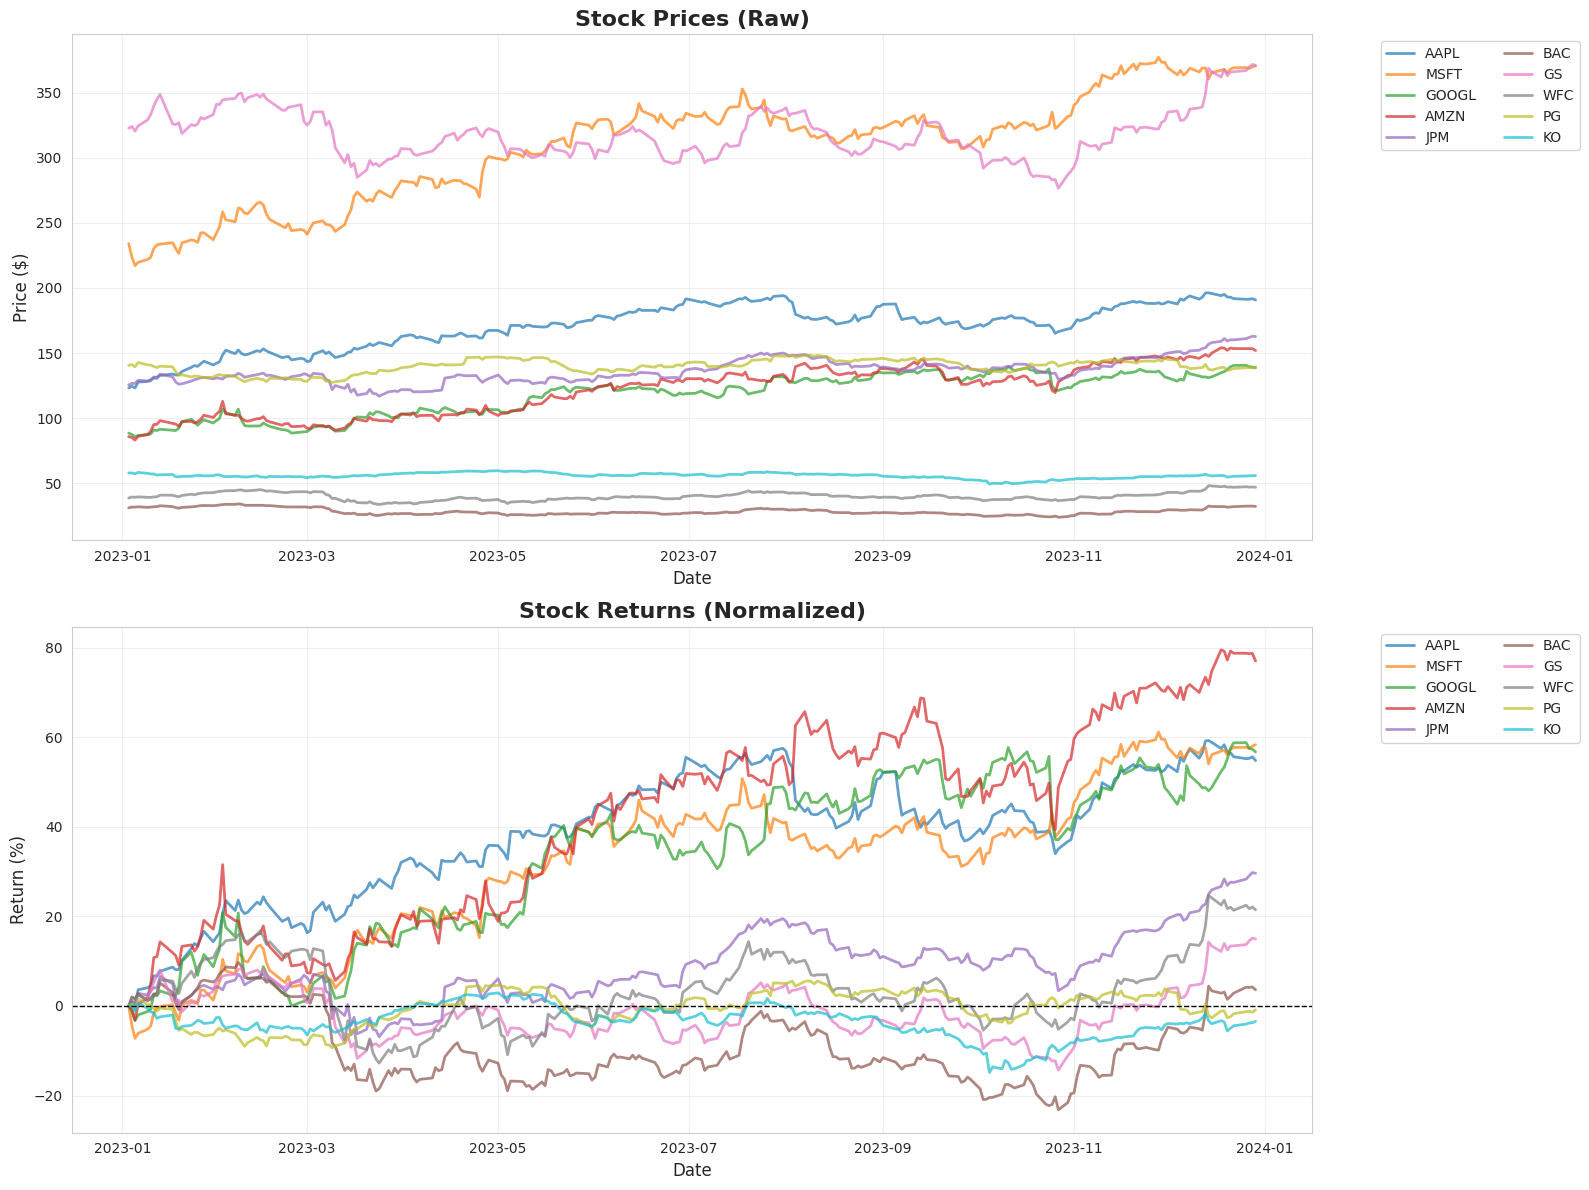

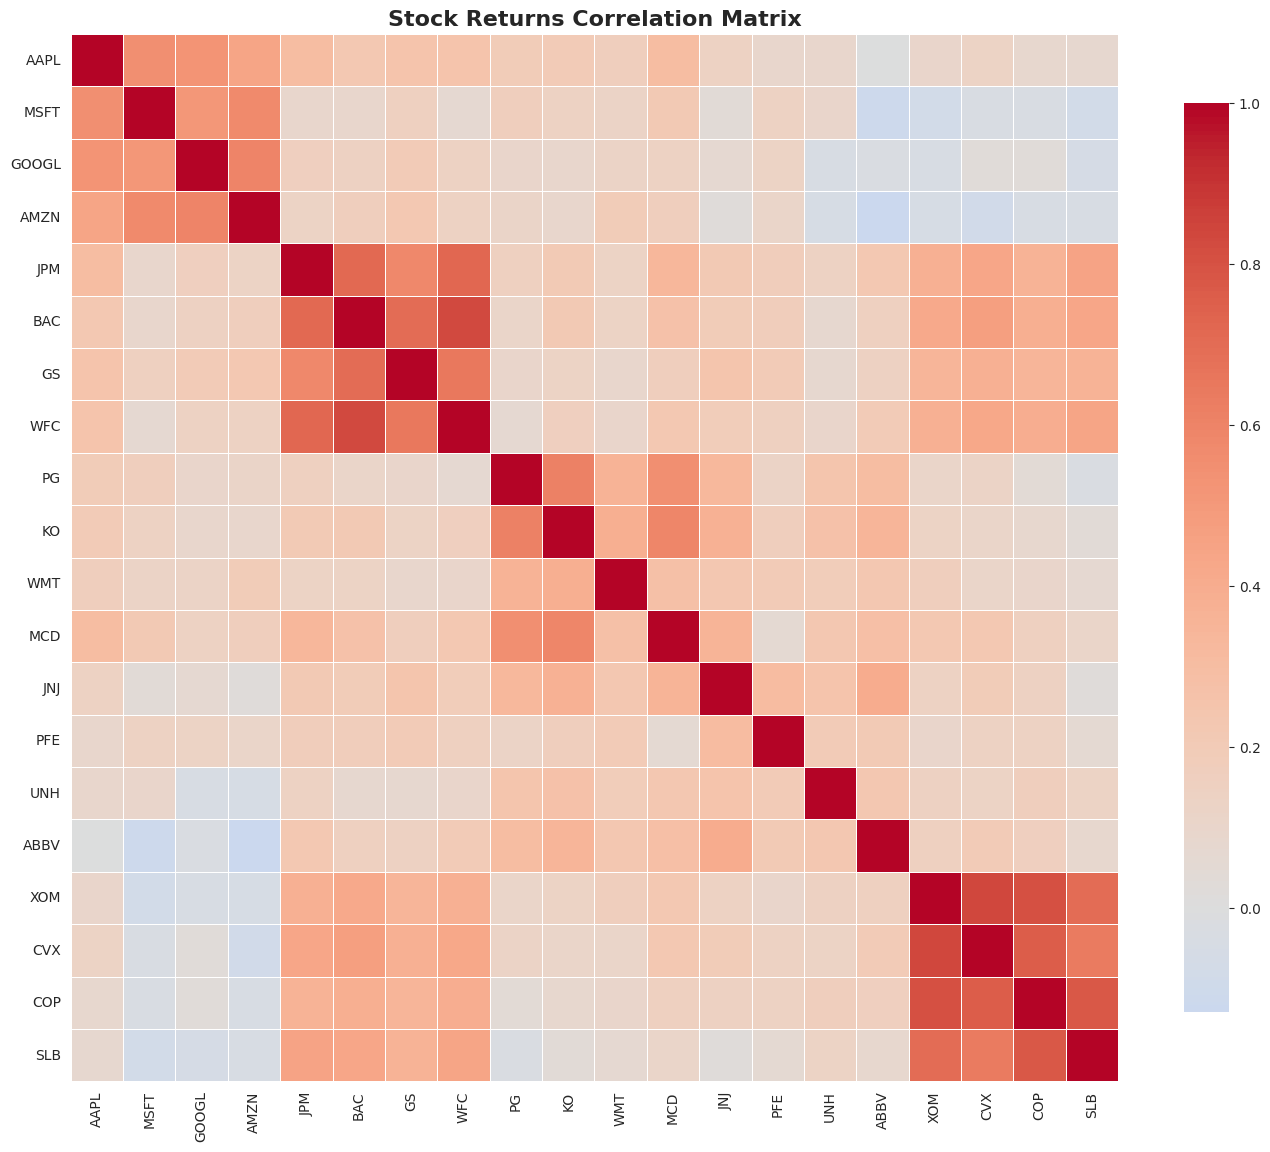

In [6]:
# Visualize stock prices
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Raw prices
for ticker in df_stocks.columns[:10]:  # Plot first 10 for clarity
    axes[0].plot(df_stocks.index, df_stocks[ticker], label=ticker, alpha=0.7, linewidth=2)

axes[0].set_title('Stock Prices (Raw)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
axes[0].grid(True, alpha=0.3)

# Plot 2: Normalized returns
for ticker in df_normalized.columns[:10]:
    axes[1].plot(df_normalized.index, df_normalized[ticker], label=ticker, alpha=0.7, linewidth=2)

axes[1].set_title('Stock Returns (Normalized)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Return (%)', fontsize=12)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = df_returns.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. DTW-Based Time Series Clustering

Dynamic Time Warping (DTW) is a technique that finds the optimal alignment between two time series, making it robust to:
- Phase shifts
- Different speeds of variation
- Local distortions

In [7]:
# Prepare data for DTW clustering
# Use normalized returns
ts_data = df_normalized.T.values  # Shape: (n_stocks, n_timepoints)

# Scale the time series
scaler = TimeSeriesScalerMeanVariance()
ts_scaled = scaler.fit_transform(ts_data)

print(f"Time series data shape: {ts_scaled.shape}")
print(f"Number of stocks: {ts_scaled.shape[0]}")
print(f"Time points per stock: {ts_scaled.shape[1]}")

Time series data shape: (20, 250, 1)
Number of stocks: 20
Time points per stock: 250


In [8]:
# DTW K-Means clustering
n_clusters = 5

print(f"Performing DTW-based K-Means clustering with {n_clusters} clusters...\n")

# Create and fit model
dtw_km = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    max_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=False
)

dtw_labels = dtw_km.fit_predict(ts_scaled)

print("Clustering complete!\n")

# Create results DataFrame
dtw_results = pd.DataFrame({
    'Ticker': df_normalized.columns,
    'Cluster': dtw_labels
})

# Display cluster assignments
print("Cluster Assignments:")
print("="*60)
for cluster_id in range(n_clusters):
    stocks_in_cluster = dtw_results[dtw_results['Cluster'] == cluster_id]['Ticker'].tolist()
    print(f"\nCluster {cluster_id}: ({len(stocks_in_cluster)} stocks)")
    print(f"  {', '.join(stocks_in_cluster)}")

print("\n" + "="*60)

Performing DTW-based K-Means clustering with 5 clusters...

Clustering complete!

Cluster Assignments:

Cluster 0: (3 stocks)
  BAC, GS, WFC

Cluster 1: (4 stocks)
  MCD, UNH, ABBV, COP

Cluster 2: (4 stocks)
  KO, JNJ, PFE, CVX

Cluster 3: (6 stocks)
  AAPL, MSFT, GOOGL, AMZN, JPM, WMT

Cluster 4: (3 stocks)
  PG, XOM, SLB



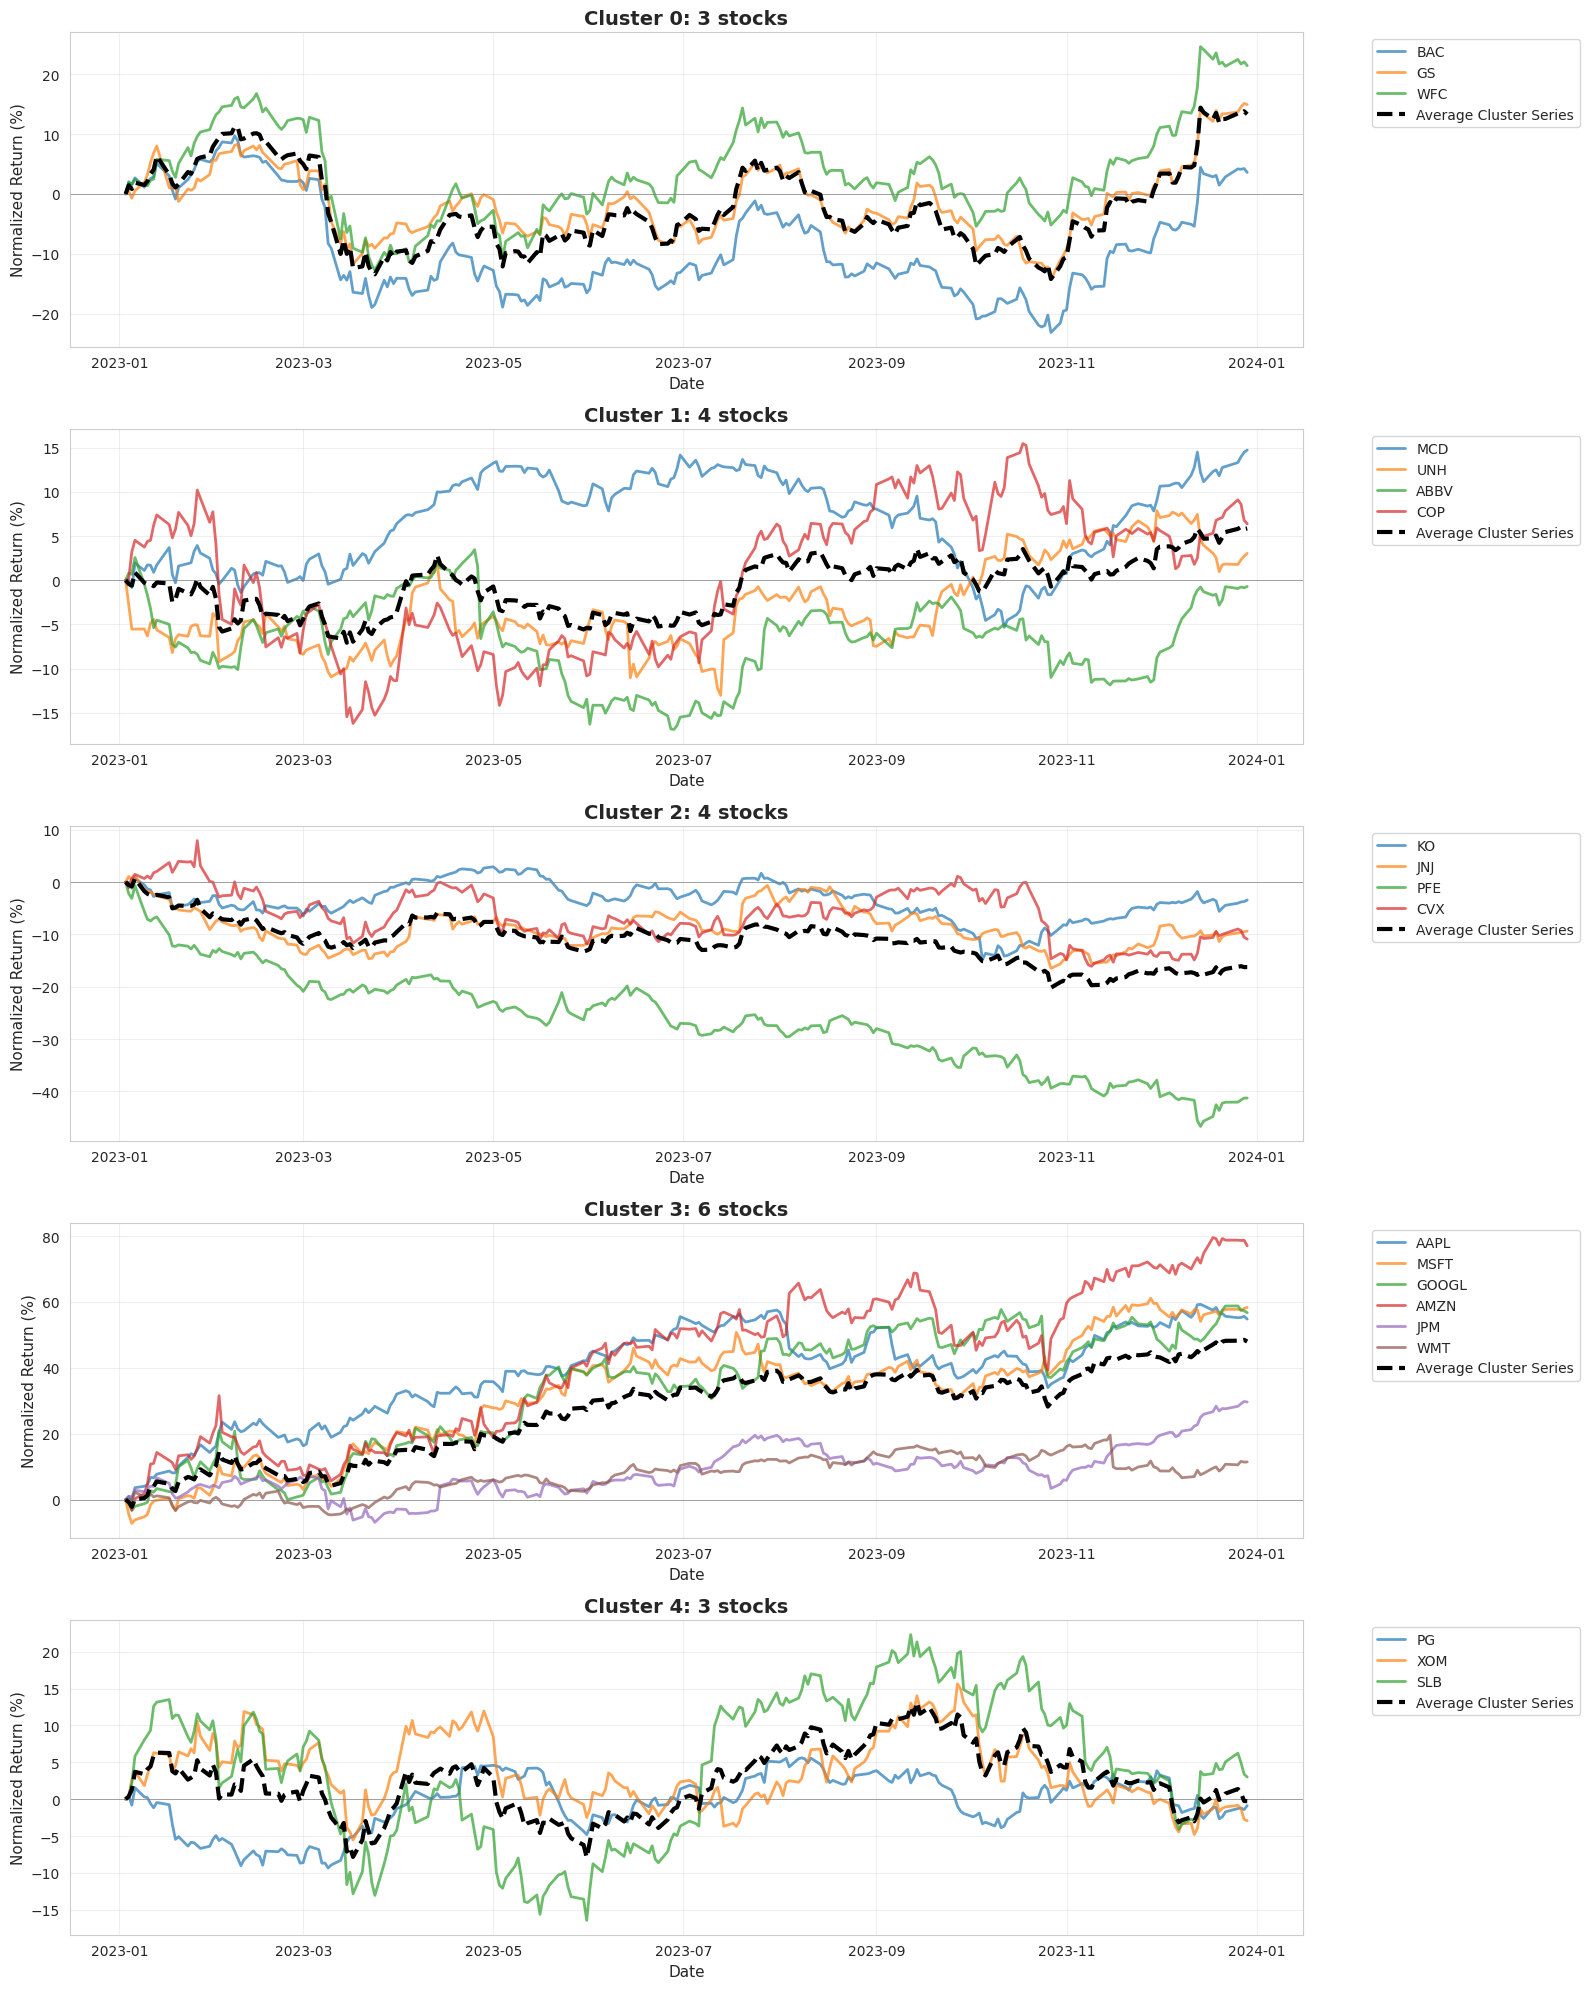

In [10]:
# Visualize DTW clustering results
fig, axes = plt.subplots(n_clusters, 1, figsize=(16, 4*n_clusters))

if n_clusters == 1:
    axes = [axes]

colors = plt.cm.tab10(np.linspace(0, 1, 10))

for cluster_id in range(n_clusters):
    cluster_stocks = dtw_results[dtw_results['Cluster'] == cluster_id]['Ticker'].tolist()

    # Plot all stocks in this cluster
    for stock in cluster_stocks:
        axes[cluster_id].plot(
            df_normalized.index,
            df_normalized[stock],
            alpha=0.7,
            linewidth=2,
            label=stock
        )

    # Plot cluster centroid
    # The TimeSeriesScalerMeanVariance does not have an inverse_transform method.
    # Instead of inverse transforming the K-Means centroid, we will plot the average
    # of the normalized returns for stocks in this cluster to represent the cluster's typical behavior.
    if cluster_stocks: # Ensure there are stocks in the cluster to average
        # Get the normalized return series for all stocks in the current cluster
        cluster_series = df_normalized[cluster_stocks]
        # Calculate the mean across these series to get an average cluster trajectory
        avg_cluster_series = cluster_series.mean(axis=1)

        axes[cluster_id].plot(
            avg_cluster_series.index,
            avg_cluster_series,
            color='black',
            linewidth=3,
            linestyle='--',
            label='Average Cluster Series', # Changed label for clarity
            zorder=10
        )
    else:
        # Handle empty clusters if they were possible (not usually for K-Means)
        axes[cluster_id].text(
            0.5, 0.5, 'No stocks in this cluster',
            horizontalalignment='center',
            verticalalignment='center',
            transform=axes[cluster_id].transAxes,
            fontsize=12, color='gray'
        )

    axes[cluster_id].set_title(
        f'Cluster {cluster_id}: {len(cluster_stocks)} stocks',
        fontsize=14,
        fontweight='bold'
    )
    axes[cluster_id].set_xlabel('Date', fontsize=11)
    axes[cluster_id].set_ylabel('Normalized Return (%)', fontsize=11)
    axes[cluster_id].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[cluster_id].grid(True, alpha=0.3)
    axes[cluster_id].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 4. Feature-Based Clustering with TSFresh

Extract statistical features from time series and cluster based on these features.

In [11]:
# Prepare data for TSFresh feature extraction
# TSFresh expects data in long format: (id, time, value)

print("Extracting time series features using TSFresh...\n")

ts_long_list = []

for ticker in df_normalized.columns:
    temp_df = pd.DataFrame({
        'id': ticker,
        'time': range(len(df_normalized)),
        'value': df_normalized[ticker].values
    })
    ts_long_list.append(temp_df)

ts_long = pd.concat(ts_long_list, ignore_index=True)

print(f"Long format data shape: {ts_long.shape}")
display(ts_long.head())

# Extract features (using a subset of features for speed)
print("\nExtracting features (this may take a minute)...")

extracted_features = extract_features(
    ts_long,
    column_id='id',
    column_sort='time',
    column_value='value',
    impute_function=impute,
    disable_progressbar=False
)

print(f"\nExtracted features shape: {extracted_features.shape}")
print(f"Number of features: {extracted_features.shape[1]}")

# Remove any NaN or inf values
extracted_features = extracted_features.replace([np.inf, -np.inf], np.nan)
extracted_features = extracted_features.fillna(0)

display(extracted_features.head())

Extracting time series features using TSFresh...

Long format data shape: (5000, 3)


,id,time,value
0,AAPL,0,0.000000
1,AAPL,1,1.031416
2,AAPL,2,-0.039983
3,AAPL,3,3.637949
4,AAPL,4,4.061720



Extracting features (this may take a minute)...


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.16it/s]



Extracted features shape: (20, 783)
Number of features: 783


,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
AAPL,1.0,0.0,0.0,1.0,9597.262708,417748.918181,1.322807,0.220073,-0.003782,40.900022,...,0.138673,0.138673,0.426954,1.711422,2.861387,3.917424,4.727217,5.136573,0.0,58.289633
ABBV,1.0,0.0,0.0,1.0,-1678.147598,16518.846103,0.809327,-0.002843,-0.001342,-6.270649,...,0.138673,0.184769,0.433803,1.720030,2.936545,4.131426,4.921815,5.299707,0.0,16.110433
AMZN,1.0,0.0,0.0,1.0,10356.793517,549831.131240,2.148421,0.309418,-0.001785,47.786067,...,0.092513,0.092513,0.219798,1.732908,2.982858,4.223589,5.000250,5.305627,0.0,78.987583
BAC,1.0,0.0,0.0,1.0,-2277.632279,37037.260452,1.116024,0.014482,-0.005093,-11.778485,...,0.204643,0.300661,0.658785,1.709525,2.885665,3.981527,4.782145,5.258901,0.0,21.806370
COP,1.0,0.0,0.0,1.0,87.177272,15460.175903,1.340795,0.025633,-0.001187,2.724153,...,0.092513,0.092513,0.311663,1.715904,2.867581,3.984954,4.782218,5.227240,0.0,15.228631


In [12]:
# Standardize features
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(extracted_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
features_pca = pca.fit_transform(features_scaled)

print(f"Original features: {features_scaled.shape[1]}")
print(f"PCA components: {features_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Cluster based on features
n_clusters_feat = 5
kmeans_feat = KMeans(n_clusters=n_clusters_feat, random_state=42, n_init=10)
feature_labels = kmeans_feat.fit_predict(features_pca)

# Create results DataFrame
feature_results = pd.DataFrame({
    'Ticker': extracted_features.index,
    'Cluster': feature_labels
})

# Display cluster assignments
print("\nFeature-Based Cluster Assignments:")
print("="*60)
for cluster_id in range(n_clusters_feat):
    stocks_in_cluster = feature_results[feature_results['Cluster'] == cluster_id]['Ticker'].tolist()
    print(f"\nCluster {cluster_id}: ({len(stocks_in_cluster)} stocks)")
    print(f"  {', '.join(stocks_in_cluster)}")

print("\n" + "="*60)

Original features: 783
PCA components: 15
Explained variance: 95.37%

Feature-Based Cluster Assignments:

Cluster 0: (3 stocks)
  BAC, GS, WFC

Cluster 1: (3 stocks)
  JPM, MCD, WMT

Cluster 2: (4 stocks)
  AAPL, AMZN, GOOGL, MSFT

Cluster 3: (6 stocks)
  ABBV, JNJ, KO, PFE, PG, UNH

Cluster 4: (4 stocks)
  COP, CVX, SLB, XOM



Creating t-SNE visualization...


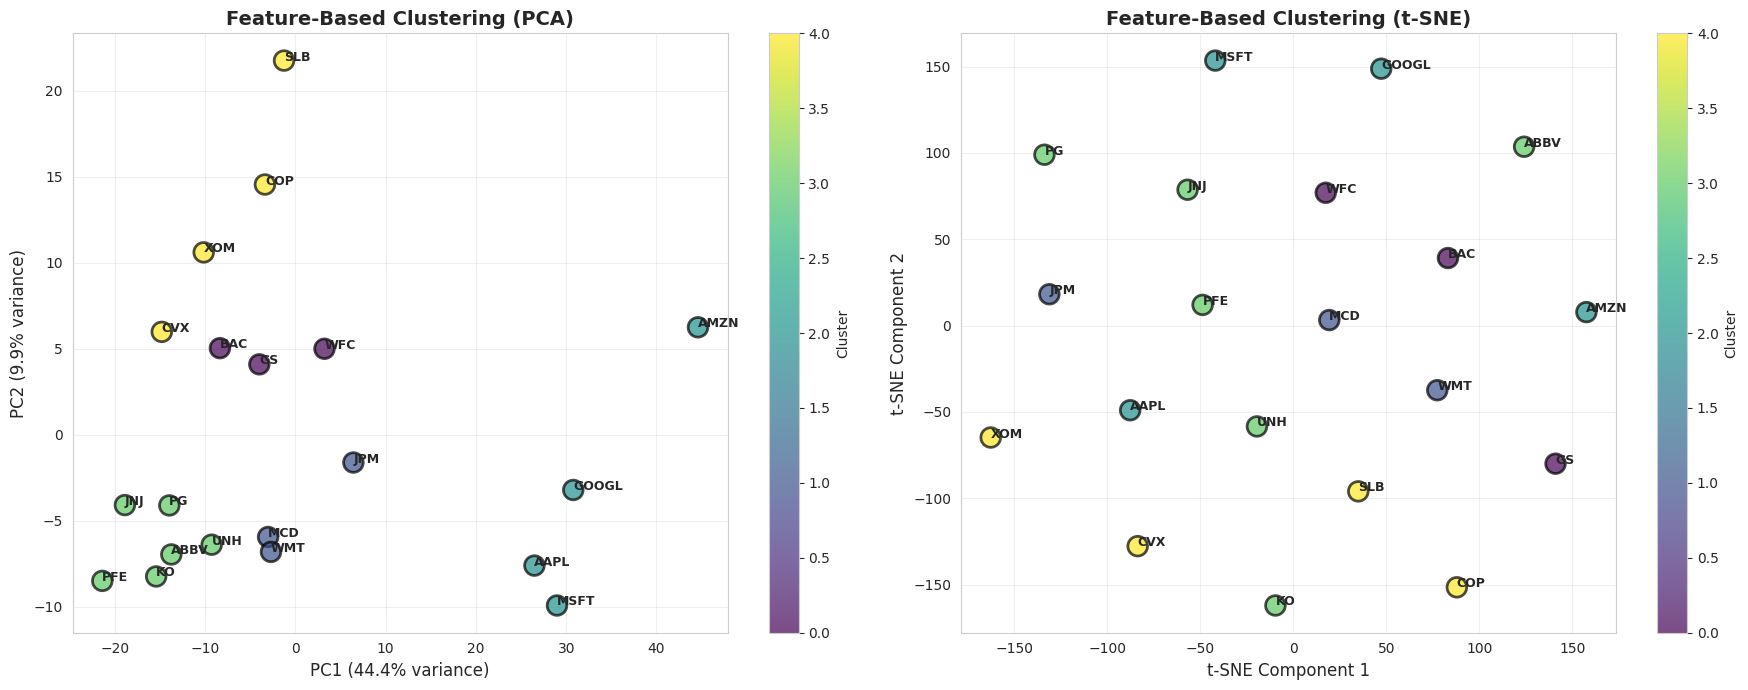

In [13]:
# Visualize feature-based clustering with t-SNE
print("Creating t-SNE visualization...")

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_pca)-1))
features_tsne = tsne.fit_transform(features_pca)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: PCA visualization
scatter1 = axes[0].scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    c=feature_labels,
    cmap='viridis',
    s=200,
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

# Add labels
for i, ticker in enumerate(feature_results['Ticker']):
    axes[0].annotate(
        ticker,
        (features_pca[i, 0], features_pca[i, 1]),
        fontsize=9,
        fontweight='bold'
    )

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title('Feature-Based Clustering (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# Plot 2: t-SNE visualization
scatter2 = axes[1].scatter(
    features_tsne[:, 0],
    features_tsne[:, 1],
    c=feature_labels,
    cmap='viridis',
    s=200,
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

# Add labels
for i, ticker in enumerate(feature_results['Ticker']):
    axes[1].annotate(
        ticker,
        (features_tsne[i, 0], features_tsne[i, 1]),
        fontsize=9,
        fontweight='bold'
    )

axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].set_title('Feature-Based Clustering (t-SNE)', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Clustering Quality Evaluation

In [14]:
# Evaluate both clustering methods
print("Clustering Quality Metrics")
print("="*80)

# For DTW clustering
print("\n1. DTW-Based K-Means:")
print("-" * 80)

# Reshape for evaluation
ts_flat = ts_scaled.reshape(ts_scaled.shape[0], -1)

if len(np.unique(dtw_labels)) > 1:
    dtw_silhouette = silhouette_score(ts_flat, dtw_labels)
    dtw_davies = davies_bouldin_score(ts_flat, dtw_labels)
    dtw_calinski = calinski_harabasz_score(ts_flat, dtw_labels)

    print(f"  Silhouette Score: {dtw_silhouette:.4f}")
    print(f"  Davies-Bouldin Index: {dtw_davies:.4f}")
    print(f"  Calinski-Harabasz Score: {dtw_calinski:.4f}")
else:
    print("  Only one cluster found. Metrics cannot be calculated.")

# For feature-based clustering
print("\n2. Feature-Based K-Means:")
print("-" * 80)

if len(np.unique(feature_labels)) > 1:
    feat_silhouette = silhouette_score(features_pca, feature_labels)
    feat_davies = davies_bouldin_score(features_pca, feature_labels)
    feat_calinski = calinski_harabasz_score(features_pca, feature_labels)

    print(f"  Silhouette Score: {feat_silhouette:.4f}")
    print(f"  Davies-Bouldin Index: {feat_davies:.4f}")
    print(f"  Calinski-Harabasz Score: {feat_calinski:.4f}")
else:
    print("  Only one cluster found. Metrics cannot be calculated.")

print("\n" + "="*80)

# Create comparison DataFrame
if len(np.unique(dtw_labels)) > 1 and len(np.unique(feature_labels)) > 1:
    comparison_metrics = pd.DataFrame({
        'Method': ['DTW K-Means', 'Feature-Based K-Means'],
        'Silhouette Score': [dtw_silhouette, feat_silhouette],
        'Davies-Bouldin Index': [dtw_davies, feat_davies],
        'Calinski-Harabasz Score': [dtw_calinski, feat_calinski]
    })

    print("\nComparison Summary:")
    display(comparison_metrics)

Clustering Quality Metrics

1. DTW-Based K-Means:
--------------------------------------------------------------------------------
  Silhouette Score: 0.1891
  Davies-Bouldin Index: 1.8776
  Calinski-Harabasz Score: 4.5382

2. Feature-Based K-Means:
--------------------------------------------------------------------------------
  Silhouette Score: 0.1557
  Davies-Bouldin Index: 1.2796
  Calinski-Harabasz Score: 5.9173


Comparison Summary:


,Method,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score
0,DTW K-Means,0.189138,1.877625,4.538227
1,Feature-Based K-Means,0.155710,1.279614,5.917318


In [15]:
# Compare cluster assignments from both methods
comparison_df = pd.DataFrame({
    'Ticker': df_normalized.columns,
    'DTW_Cluster': dtw_labels,
    'Feature_Cluster': feature_labels
})

print("\nCluster Assignment Comparison:")
print("="*60)
display(comparison_df.sort_values('DTW_Cluster'))

# Check agreement between methods
# Normalize cluster IDs and check consistency
agreement_score = (comparison_df['DTW_Cluster'] == comparison_df['Feature_Cluster']).sum() / len(comparison_df)
print(f"\nDirect agreement between methods: {agreement_score:.2%}")
print("Note: Different cluster IDs don't necessarily mean disagreement,")
print("as cluster numbering may differ between methods.")


Cluster Assignment Comparison:


,Ticker,DTW_Cluster,Feature_Cluster
6,GS,0,2
7,WFC,0,0
5,BAC,0,4
11,MCD,1,1
15,ABBV,1,4
14,UNH,1,3
18,COP,1,1
9,KO,2,1
12,JNJ,2,2
13,PFE,2,3



Direct agreement between methods: 35.00%
Note: Different cluster IDs don't necessarily mean disagreement,
as cluster numbering may differ between methods.


## 6. Hierarchical Clustering with Dendrogram

Performing hierarchical clustering...


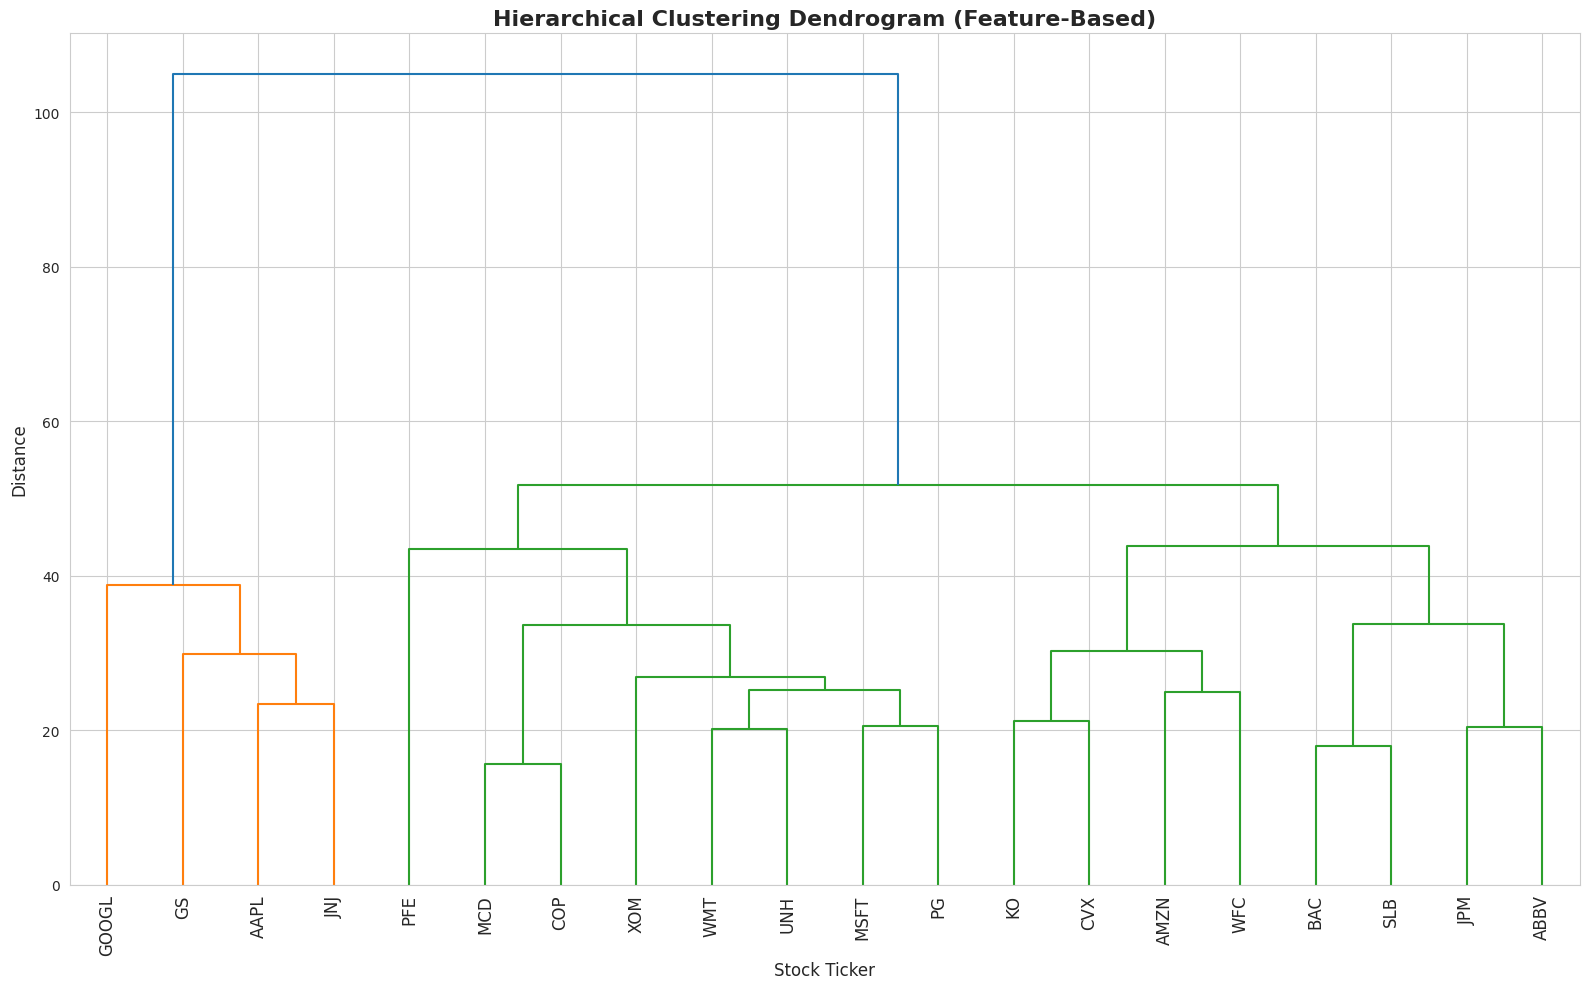


Hierarchical Cluster Assignments:

Cluster 0: (4 stocks)
  AAPL, GOOGL, GS, JNJ

Cluster 1: (7 stocks)
  MSFT, PG, WMT, MCD, UNH, XOM, COP

Cluster 2: (4 stocks)
  JPM, BAC, ABBV, SLB

Cluster 3: (4 stocks)
  AMZN, WFC, KO, CVX

Cluster 4: (1 stocks)
  PFE


In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering on features
print("Performing hierarchical clustering...")

linkage_matrix = linkage(features_pca, method='ward')

# Create dendrogram
plt.figure(figsize=(16, 10))
dendrogram(
    linkage_matrix,
    labels=comparison_df['Ticker'].values,
    leaf_font_size=12,
    leaf_rotation=90
)
plt.title('Hierarchical Clustering Dendrogram (Feature-Based)',
          fontsize=16, fontweight='bold')
plt.xlabel('Stock Ticker', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

# Apply hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(features_pca)

print("\nHierarchical Cluster Assignments:")
print("="*60)
for cluster_id in range(5):
    stocks = comparison_df['Ticker'][hierarchical_labels == cluster_id].tolist()
    print(f"\nCluster {cluster_id}: ({len(stocks)} stocks)")
    print(f"  {', '.join(stocks)}")

## 7. Determine Optimal Number of Clusters

Testing different numbers of clusters...

k=2: Silhouette=0.3864, Davies-Bouldin=0.9509
k=3: Silhouette=0.1683, Davies-Bouldin=1.6367
k=4: Silhouette=0.1755, Davies-Bouldin=1.4058
k=5: Silhouette=0.1557, Davies-Bouldin=1.2796
k=6: Silhouette=0.1574, Davies-Bouldin=1.2280
k=7: Silhouette=0.1135, Davies-Bouldin=1.1032
k=8: Silhouette=0.1561, Davies-Bouldin=0.9679
k=9: Silhouette=0.1437, Davies-Bouldin=0.9062
k=10: Silhouette=0.1305, Davies-Bouldin=0.8231


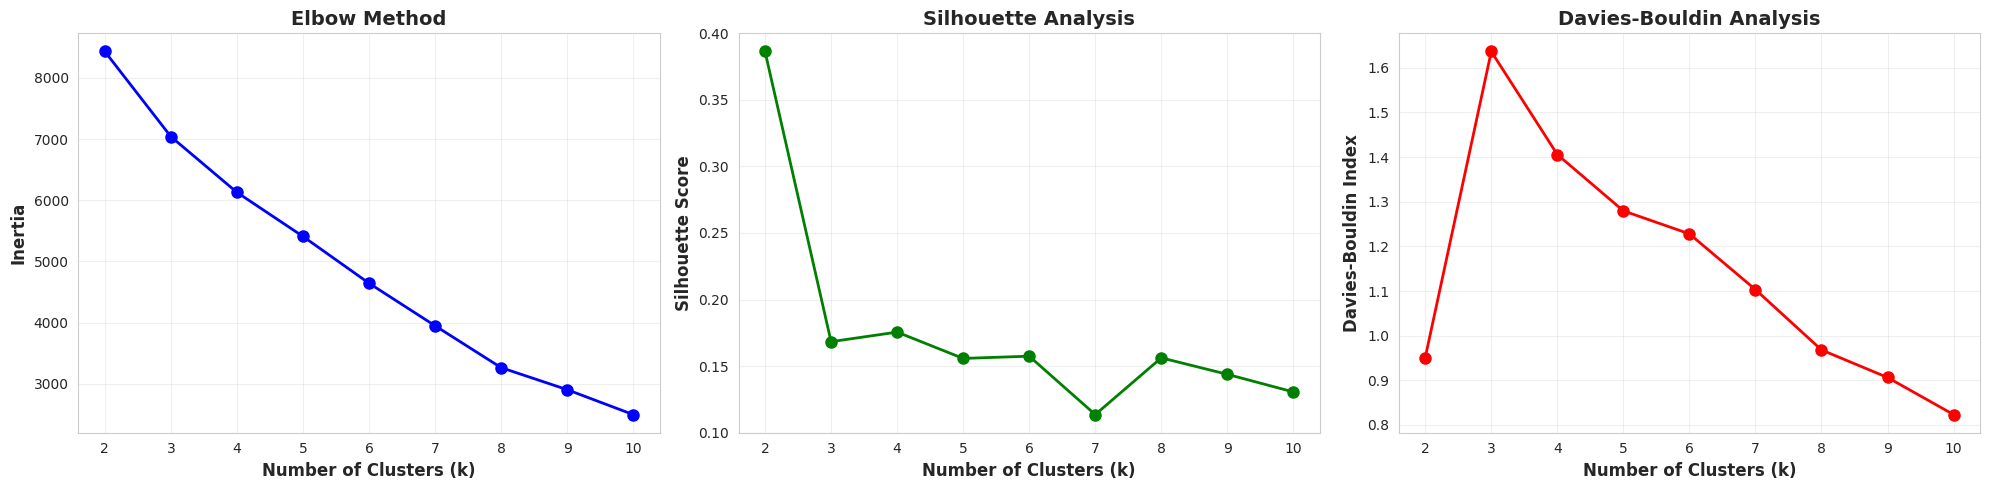


Optimal number of clusters:
  Based on Silhouette Score: k = 2
  Based on Davies-Bouldin Index: k = 10


In [17]:
# Elbow method and silhouette analysis
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Testing different numbers of clusters...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_pca)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(features_pca, labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.4f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.4f}")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Davies-Bouldin plot
axes[2].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin Analysis', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]

print(f"\nOptimal number of clusters:")
print(f"  Based on Silhouette Score: k = {optimal_k_silhouette}")
print(f"  Based on Davies-Bouldin Index: k = {optimal_k_db}")

## 8. Cluster Interpretation and Insights

In [18]:
# Analyze cluster characteristics
print("Cluster Characteristics Analysis")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_stocks = dtw_results[dtw_results['Cluster'] == cluster_id]['Ticker'].tolist()
    cluster_data = df_normalized[cluster_stocks]
    cluster_returns = df_returns[cluster_stocks]

    print(f"\nCluster {cluster_id}:")
    print("-" * 80)
    print(f"Stocks: {', '.join(cluster_stocks)}")
    print(f"\nStatistics:")
    print(f"  Average Return: {cluster_data.mean().mean():.2f}%")
    print(f"  Return Std Dev: {cluster_returns.std().mean():.4f}")
    print(f"  Max Drawdown: {(cluster_data.min().mean()):.2f}%")
    print(f"  Max Gain: {(cluster_data.max().mean()):.2f}%")

    # Correlation within cluster
    if len(cluster_stocks) > 1:
        avg_corr = cluster_returns.corr().values[np.triu_indices_from(
            cluster_returns.corr().values, k=1)].mean()
        print(f"  Average Intra-cluster Correlation: {avg_corr:.4f}")
    else:
        print(f"  Average Intra-cluster Correlation: N/A (single stock)")

print("\n" + "="*80)

Cluster Characteristics Analysis

Cluster 0:
--------------------------------------------------------------------------------
Stocks: BAC, GS, WFC

Statistics:
  Average Return: -2.41%
  Return Std Dev: 0.0165
  Max Drawdown: -16.74%
  Max Gain: 16.51%
  Average Intra-cluster Correlation: 0.7261

Cluster 1:
--------------------------------------------------------------------------------
Stocks: MCD, UNH, ABBV, COP

Statistics:
  Average Return: -0.70%
  Return Std Dev: 0.0131
  Max Drawdown: -12.84%
  Max Gain: 10.37%
  Average Intra-cluster Correlation: 0.2057

Cluster 2:
--------------------------------------------------------------------------------
Stocks: KO, JNJ, PFE, CVX

Statistics:
  Average Return: -11.29%
  Return Std Dev: 0.0120
  Max Drawdown: -23.53%
  Max Gain: 3.00%
  Average Intra-cluster Correlation: 0.2153

Cluster 3:
--------------------------------------------------------------------------------
Stocks: AAPL, MSFT, GOOGL, AMZN, JPM, WMT

Statistics:
  Average Retur

Sector Distribution Across Clusters


Sector,Consumer,Energy,Finance,Healthcare,Tech,All
Cluster,,,,,,
0,0,0,3,0,0,3
1,1,1,0,2,0,4
2,1,1,0,2,0,4
3,1,0,1,0,4,6
4,1,2,0,0,0,3
All,4,4,4,4,4,20


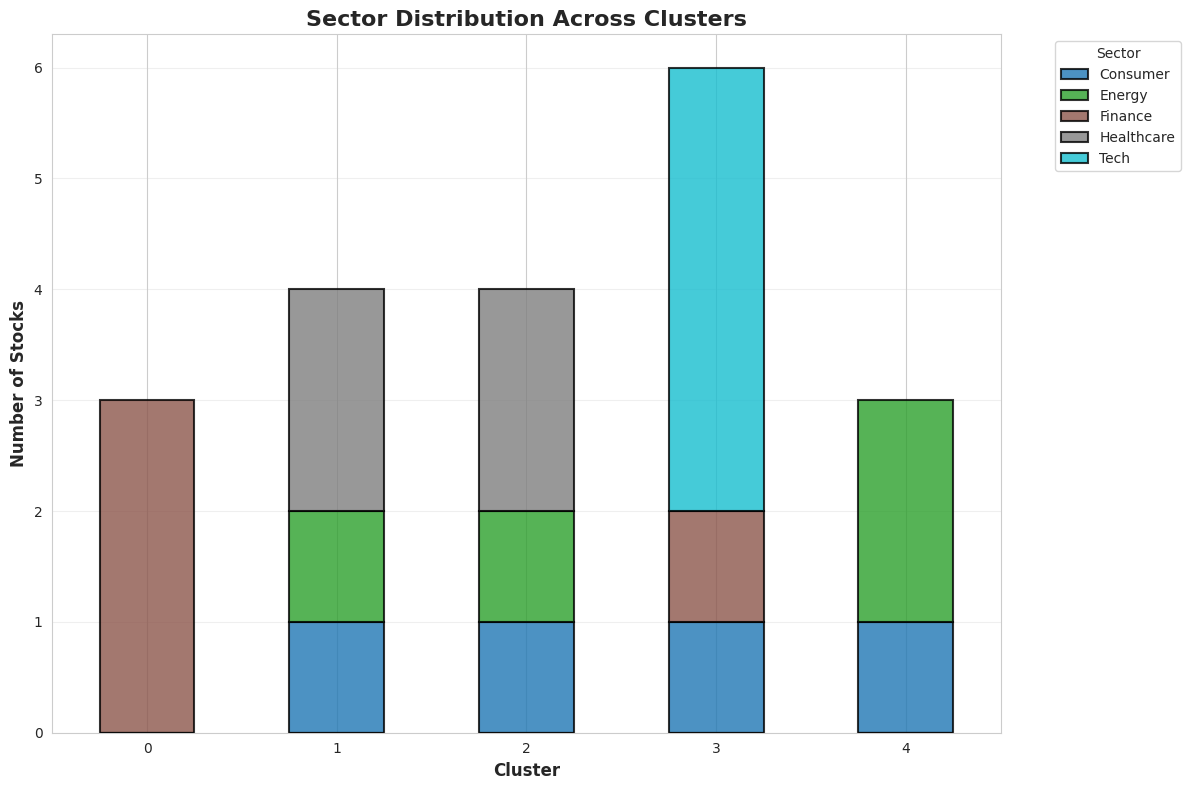


Insight: Clusters with stocks from the same sector indicate
that sector-specific factors drive similar price movements.


In [19]:
# Map stocks to sectors
sector_mapping = {
    'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'AMZN': 'Tech',
    'JPM': 'Finance', 'BAC': 'Finance', 'GS': 'Finance', 'WFC': 'Finance',
    'PG': 'Consumer', 'KO': 'Consumer', 'WMT': 'Consumer', 'MCD': 'Consumer',
    'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare', 'ABBV': 'Healthcare',
    'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy'
}

# Add sector information to results
dtw_results['Sector'] = dtw_results['Ticker'].map(sector_mapping)

# Analyze sector distribution across clusters
print("Sector Distribution Across Clusters")
print("="*80)

sector_cluster_dist = pd.crosstab(
    dtw_results['Cluster'],
    dtw_results['Sector'],
    margins=True
)

display(sector_cluster_dist)

# Visualize sector distribution
fig, ax = plt.subplots(figsize=(12, 8))
sector_cluster_dist_no_margin = sector_cluster_dist.iloc[:-1, :-1]
sector_cluster_dist_no_margin.plot(kind='bar', stacked=True, ax=ax,
                                    colormap='tab10', alpha=0.8,
                                    edgecolor='black', linewidth=1.5)
ax.set_title('Sector Distribution Across Clusters', fontsize=16, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Stocks', fontsize=12, fontweight='bold')
ax.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInsight: Clusters with stocks from the same sector indicate")
print("that sector-specific factors drive similar price movements.")

## 9. Conclusion and Best Practices

### Key Findings:

#### 1. DTW-Based Clustering:
- **Strengths**:
  - Captures shape similarity regardless of phase shifts
  - Works well for comparing temporal patterns
  - Robust to time warping and different speeds
- **Weaknesses**:
  - Computationally expensive for large datasets
  - Sensitive to time series length
  - May not capture all relevant features

#### 2. Feature-Based Clustering:
- **Strengths**:
  - Fast and scalable
  - Can incorporate domain knowledge through feature engineering
  - Works with standard clustering algorithms
- **Weaknesses**:
  - May lose temporal information
  - Requires good feature selection
  - Feature extraction can be time-consuming

#### 3. Choosing the Right Approach:
- **DTW**: When temporal pattern shape is most important
- **Features**: When specific statistical properties matter
- **Combination**: Use both and compare results for robustness

### Time Series Clustering Best Practices:

1. **Data Preprocessing**:
   - Normalize/standardize time series
   - Handle missing values appropriately
   - Remove trends if needed
   - Consider seasonality

2. **Feature Selection**:
   - Statistical: mean, std, skewness, kurtosis
   - Temporal: autocorrelation, trend, seasonality
   - Frequency domain: FFT components
   - Domain-specific features

3. **Evaluation**:
   - Use multiple metrics (Silhouette, Davies-Bouldin, Calinski-Harabasz)
   - Validate with domain knowledge
   - Check cluster stability with different parameters
   - Visualize results in reduced dimensions

4. **Optimal Cluster Selection**:
   - Elbow method for inertia
   - Silhouette analysis
   - Davies-Bouldin index
   - Domain knowledge and business requirements

### Interpretation Guidelines:

1. **Stock Clustering Insights**:
   - Stocks in same cluster tend to move together
   - Can inform portfolio diversification
   - Reveals sector correlations
   - Identifies market regimes

2. **Practical Applications**:
   - **Portfolio Management**: Diversify across clusters
   - **Risk Management**: Monitor cluster correlations
   - **Pairs Trading**: Identify co-moving stocks
   - **Market Analysis**: Understand sector dynamics

### Advanced Techniques:

1. **Deep Learning Approaches**:
   - Autoencoders for learning embeddings
   - LSTM-based feature extraction
   - Transformer models for time series

2. **Hybrid Methods**:
   - Combine DTW with clustering
   - Use features + raw data
   - Ensemble different approaches

3. **Online Clustering**:
   - Update clusters as new data arrives
   - Detect cluster drift
   - Adaptive algorithms

### Tools and Libraries:

- **tslearn**: DTW-based clustering, time series preprocessing
- **tsfresh**: Comprehensive feature extraction
- **sktime**: Time series machine learning
- **stumpy**: Fast similarity search
- **prophet**: Forecasting with decomposition

### Next Steps:

1. Experiment with different distance metrics
2. Try HDBSCAN for automatic cluster detection
3. Implement deep learning embeddings
4. Build a real-time clustering pipeline
5. Create interpretable cluster profiles